In [1]:

import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
import obspy

import torch
from chronos import ChronosPipeline
import numpy as np

## Get an earthquake waveform

In [3]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 6
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)
print(quake_catalog)

2 Event(s) in Catalog:
2019-07-06T03:19:53.040000Z | +35.770, -117.599 | 7.1  Mw | manual
2019-07-04T17:33:49.000000Z | +35.705, -117.504 | 6.4  Mw | manual


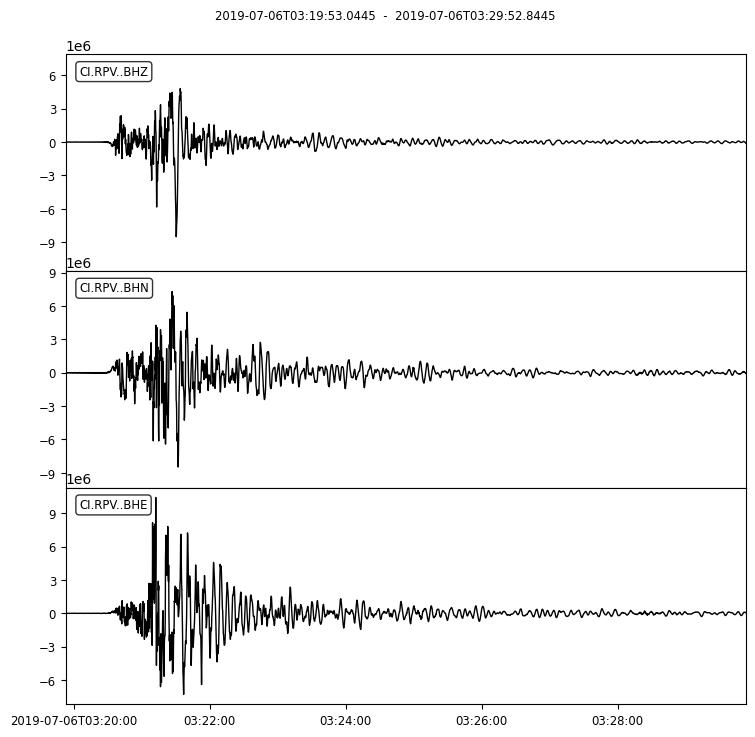

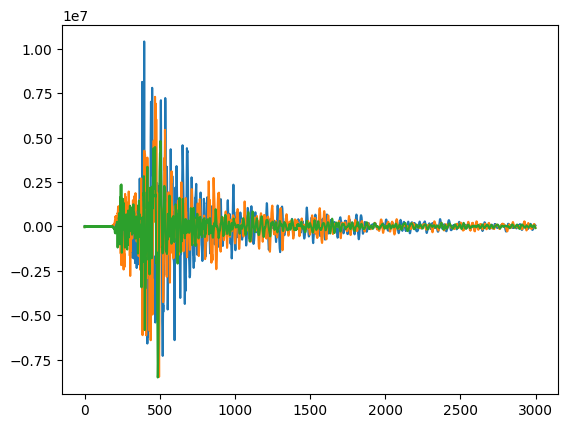

In [66]:
# get a seismogram from CI.RPV..BHZ for the large earthquake in the first element of quake_catalog
event = quake_catalog[0]
origin = event.origins[0]
# convert the origin time to a UTCDateTime object
event_time = obspy.UTCDateTime(origin.time)
z=client.get_waveforms("CI", "RPV", "", "BH*", event_time, event_time + 60*10)
# downsample to df Hz

df = 5
z.resample(df)
z.plot()
data = np.zeros(shape=(3, len(z[0].data)))
data[0] = z[0].data
data[1] = z[1].data
data[2] = z[2].data
plt.plot(data.T)


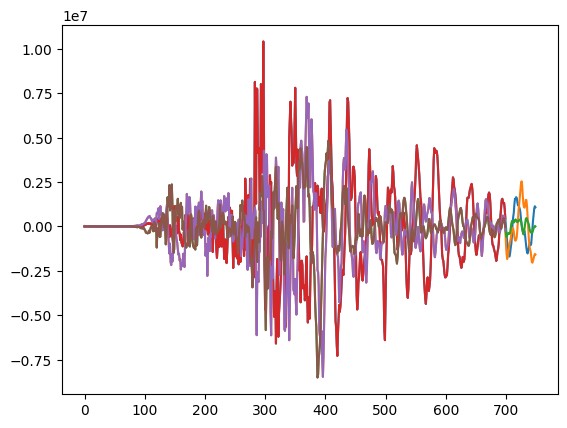

In [69]:
# now we are going to reshape the data into a format that can be used by the ChronosPipeline
# data = np.expand_dims(data, axis=0)
prediction_length = int(10*df)
last_date = int(160*df)
start_date = int(20*df)
#create a time vector with sampling rate df
time = np



plt.plot(data[:,start_date:last_date+prediction_length].T)
plt.plot(data[:,start_date:last_date].T);

In [70]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(data[:,start_date:last_date], dtype=torch.float32),
    prediction_length=prediction_length,
    num_samples=20,
)

In [50]:
print(forecast.shape)

torch.Size([3, 20, 16])


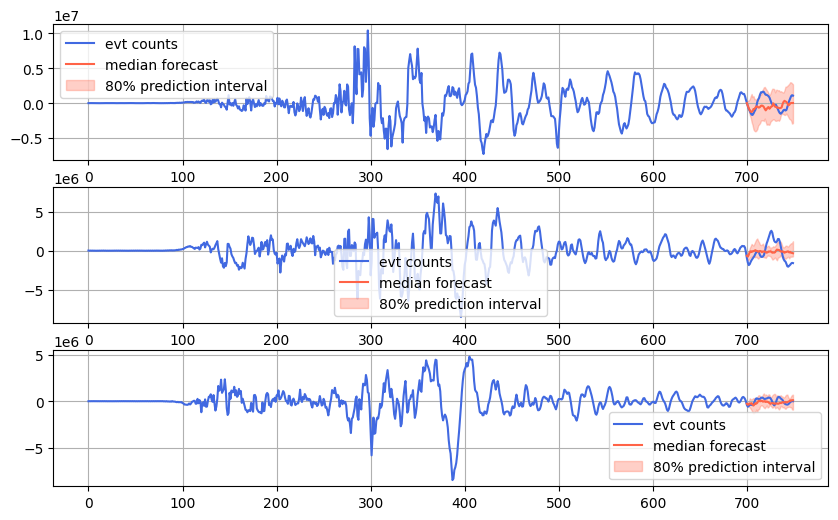

In [72]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(last_date-start_date, last_date + prediction_length-start_date)
low, median, high = np.quantile(forecast[:,:,:].numpy(), [0.1, 0.5, 0.9], axis=1)

# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index


# Create a new date range for the forecast

fig,ax=plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
for ii in range(data.shape[0]):
    ax[ii].plot(data[ii,start_date:last_date+prediction_length], color="royalblue", label="evt counts")
    ax[ii].plot(forecast_index, median[ii,:], color="tomato", label="median forecast")
    ax[ii].fill_between(forecast_index, low[ii,:], high[ii,], color="tomato", alpha=0.3, label="80% prediction interval")   
    ax[ii].legend()
    ax[ii].grid()